# Train model with annual and seasonal observations

In [133]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_prediction_subplot

In [134]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\3940554349.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


Annual mass balance: 3910 entries <br>
Summer mass balance: 3929 entries <br>
Winter mass balance: 3752 entries <br>

In [135]:
# Manually select test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2320, 2478, 2769, 3127, 3141]

df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# 54 has 189 points
# 703 has 30 points
# 941 has 70 points
# 1280 has 71 points
# 2320 has 83 points
# 2478 has 89 points
# 2769 has 121 points
# 3127 has 145 points
# 3141 has 72 points
# Test dataset has 926 points in total, approximately 24% of the data
# Train dataset has 2984 points, approximately 76% of the data

df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

Train/test annual: 2984/926 <br>
Train/test winter: 2889/863 <br>
Train/test summer: 3039/890 <br>
All train/test: 8912 / 2679 <br>
Total entries: 11591 (test is 23%, train is 77%) <br>

In [136]:
# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6

C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\1628288660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\1628288660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\1628288660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [137]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_net = ['str_oct','str_nov','str_dec','str_jan','str_feb','str_mar','str_apr','str_may','str_jun','str_jul','str_aug','str_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']
lat_hflux = ['slhf_oct','slhf_nov','slhf_dec','slhf_jan','slhf_feb','slhf_mar','slhf_apr','slhf_may','slhf_jun','slhf_jul','slhf_aug','slhf_sep']
sen_hflux = ['sshf_oct','sshf_nov','sshf_dec','sshf_jan','sshf_feb','sshf_mar','sshf_apr','sshf_may','sshf_jun','sshf_jul','sshf_aug','sshf_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, 
                         snow_temp, snow_melt, snowfall, snow_albedo, dewpt_temp, surface_pressure, 
                         sol_rad_down, sol_therm_down,
                        sol_rad_net, sol_therm_net, u_wind, v_wind, f_albedo, lat_hflux, sen_hflux ] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

In [138]:
# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)

#var = ['u10', 'v10', 't2m', 'fal', 'sshf', 'slhf', 'ssr', 'str', 'tp']
var = ['t2m', 'tp'] # Training only temp & prec

mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan
        
    

In [139]:
# Combine the three dataframes
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])
df_train_all.reset_index(drop=True, inplace=True)

df_train_a_w_s_all = pd.concat([df_train_annual, df_train_summer, df_train_winter])
df_train_a_w_s_all.reset_index(drop=True, inplace=True)

In [140]:
# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
idx_train_s = df_train_s.index
df_train_s.reset_index(drop=True, inplace=True)

# Shuffle dataframe to be used in plots according to shuffled index of training dataset
df_train_a_w_s_all_s = df_train_a_w_s_all.reindex(idx_train_s)
df_train_a_w_s_all_s.reset_index(drop=True, inplace=True)

In [141]:
# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [142]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [143]:
print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2085 2148 2474 2514 2597 2743 2768 2772
 2968 3126 3128 3129 3133 3137 3138]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2085 2148 2297 2474 2514 2597 2743 2768 2772
 2968 3126 3128 3129 3133 3137 3138]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2085 2297 2514 2597 2743 2768 2772 2968 3128
 3129 3133]
Validation, fold 2:  [1094 2148 2474 3126 3137 3138]
Train, fold 3:  [ 596 1094 2078 2085 2148 2297 2474 2743 2768 2968 3126 3129 3133 3137
 3138]
Validation, fold 3:  [ 675 1092 1144 2514 2597 2772 3128]
Train, fold 4:  [ 675 1092 1094 1144 2078 2148 2297 2474 2514 2597 2772 3126 3128 3137
 3138]
Validation, fold 4:  [ 596 2085 2743 2768 2968 3129 3133]


In [56]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 462 candidates, totalling 2310 fits
Cross validation score:  -1.1410544518818224
Grid search best hyperparameters:  {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 700}
Cross validation scores per fold:  [-1.50859856 -0.81003521 -0.96979403 -1.16194433 -1.25490013]
Mean cross validation score:  -1.1410544518818224
Standard deviation:  0.23974560191481648


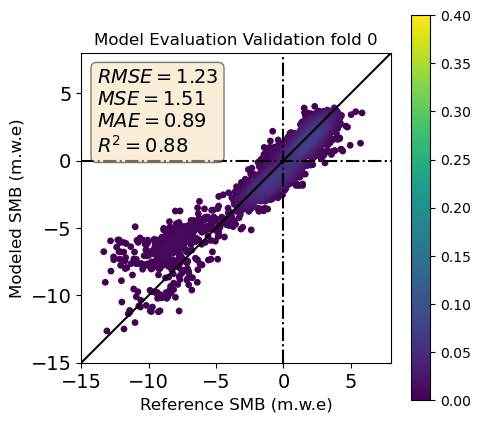

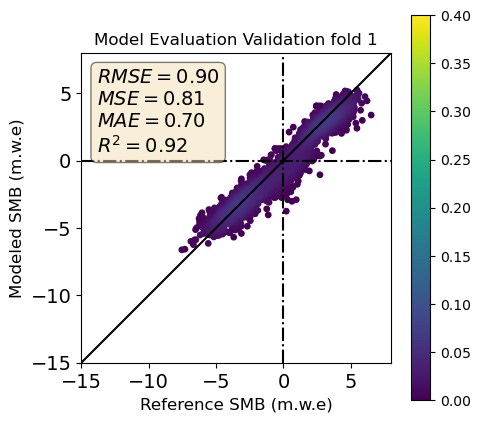

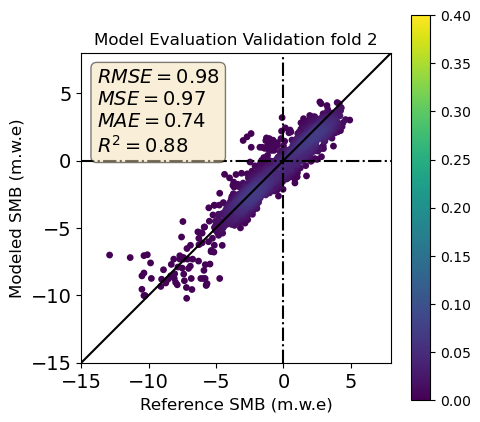

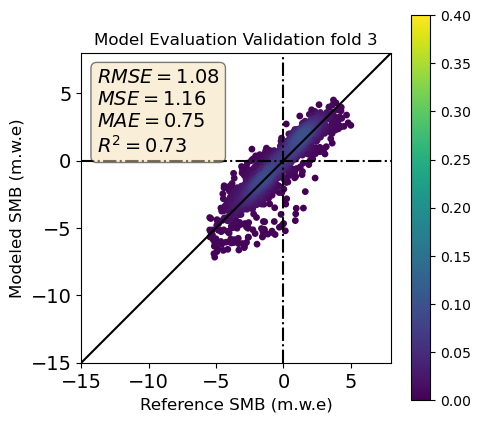

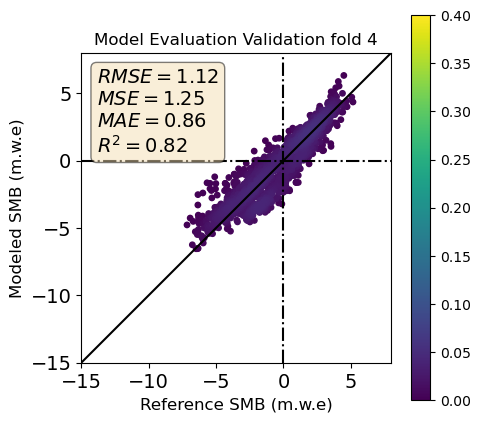

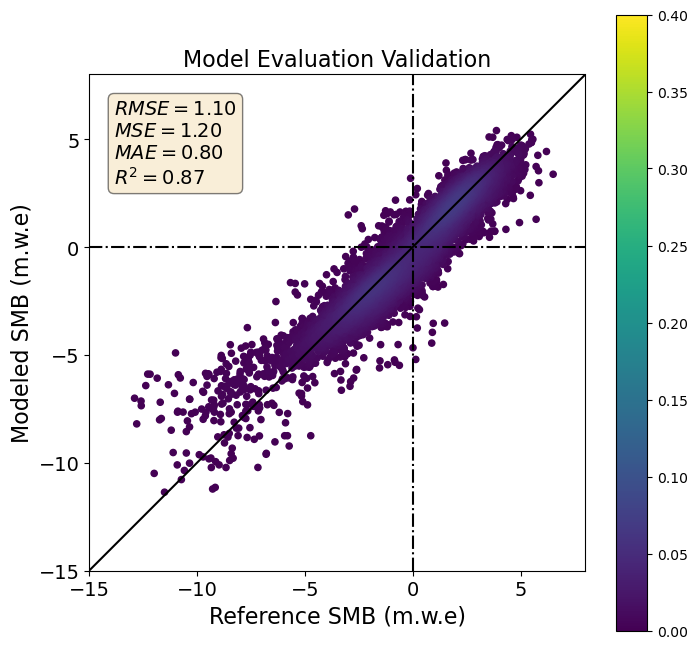

In [34]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [144]:
# Save cv-object
#joblib.dump(cv_grid, 'Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_temp_prec_700_trees.pkl')
cv_grid = joblib.load('Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_temp_prec_700_trees.pkl')

In [145]:
best_model = cv_grid.best_estimator_


In [37]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\184212899.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


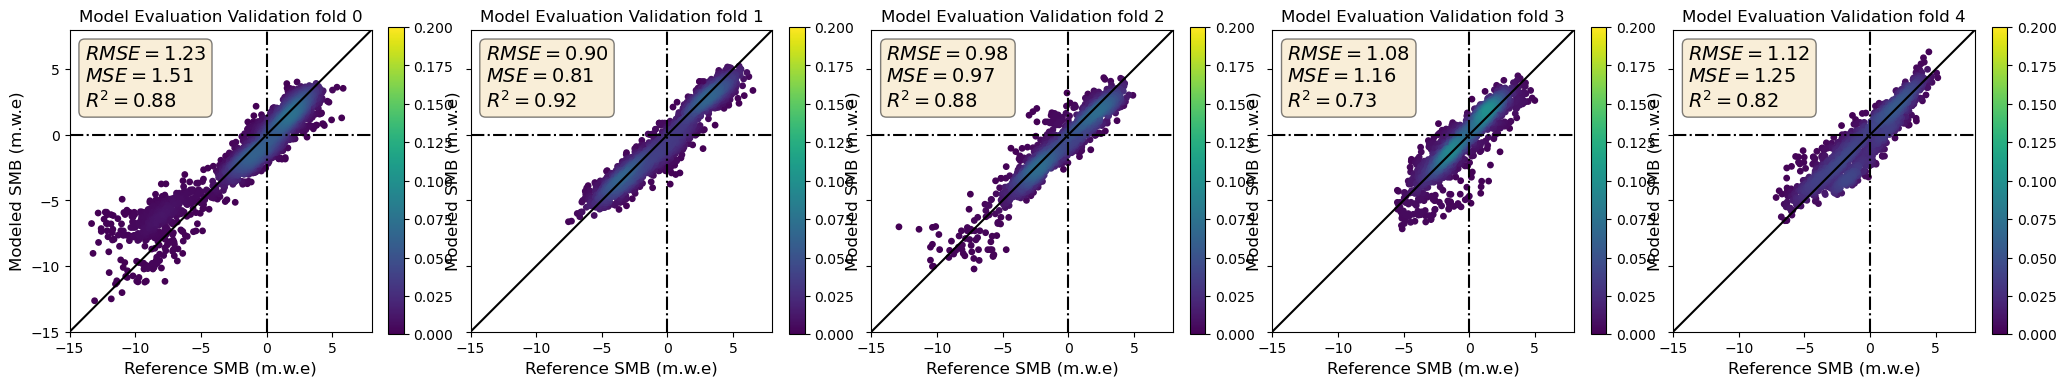

In [38]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\3150757613.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


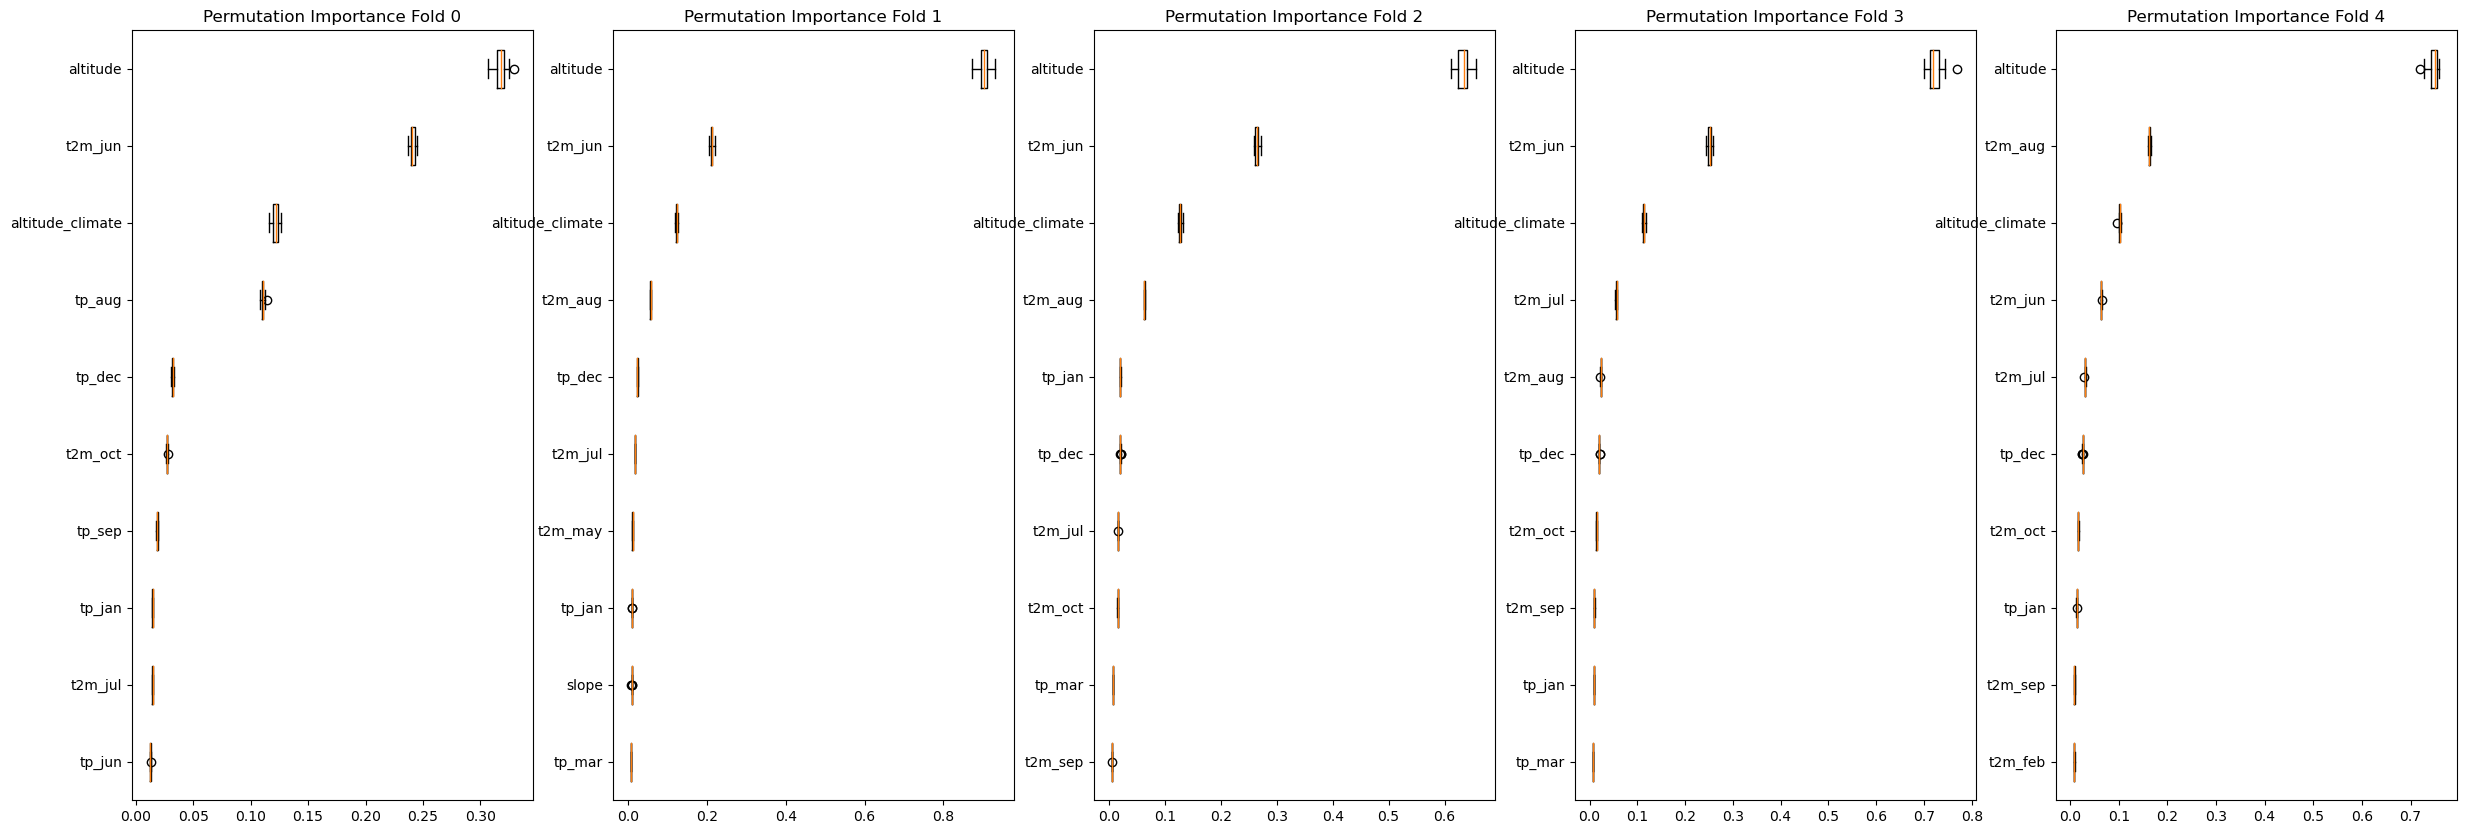

In [59]:
# Plot permutation importance

max_features_plot = 10

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]

    best_model.fit(X_train, y_train)
    
    result = permutation_importance(best_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

    sorted_idx = result.importances_mean.argsort()
    labels = np.array(df_train_X_s.columns)[sorted_idx][-max_features_plot:]
    
    ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
    ax[a].set_title("Permutation Importance Fold " + str(a))

    a=a+1

fig.show()

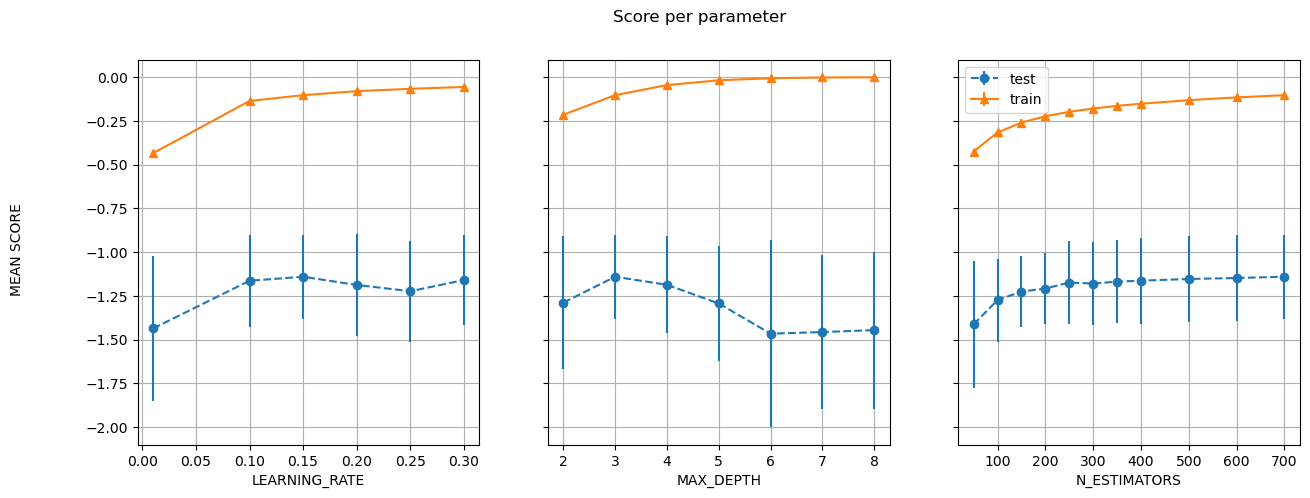

In [40]:
plot_gsearch_results(cv_grid)

ValueError: kth(=-20) out of bounds (30)

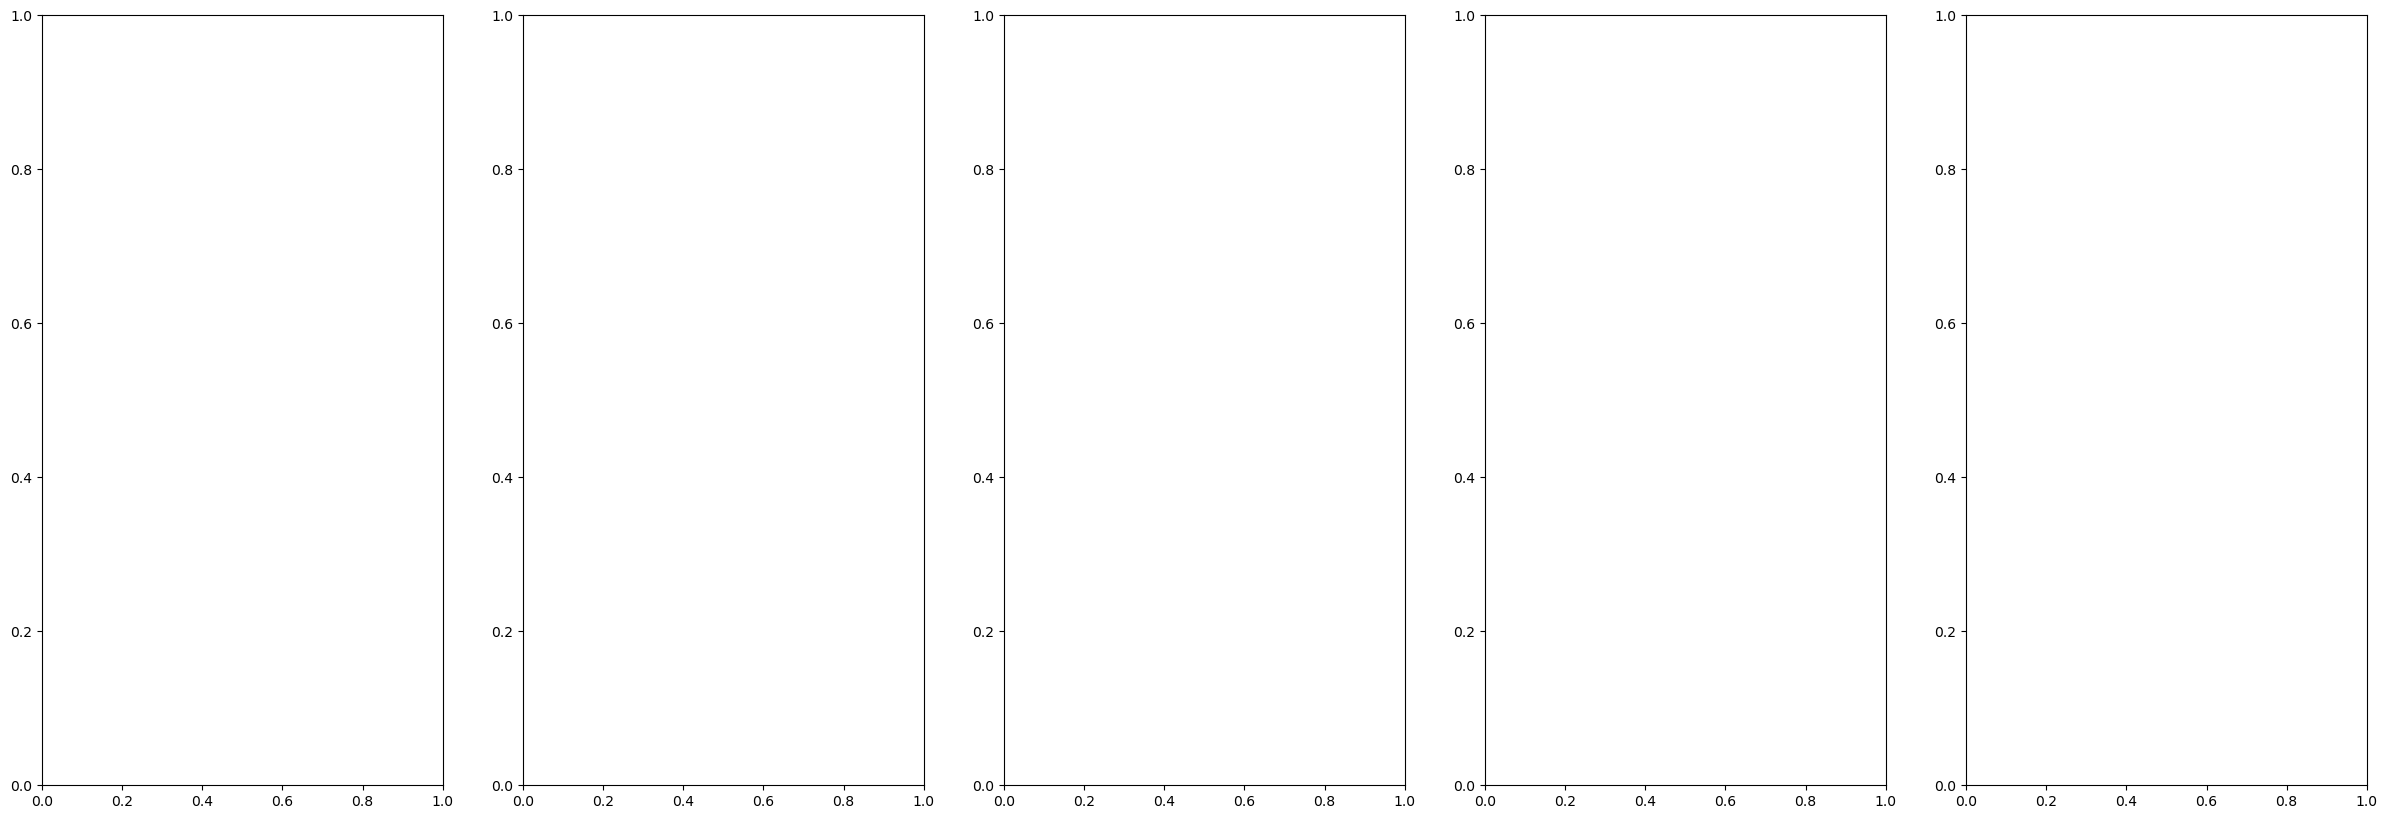

In [41]:
max_features_plot = 50

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    
    best_model.fit(X_train, y_train)
    feature_importance = best_model.feature_importances_
    ind = np.argpartition(feature_importance, -max_features_plot)[-max_features_plot:]
    feature_importance_50 = feature_importance[ind]
    sorted_idx = np.argsort(feature_importance_50)
    y_cols = np.array(df_train_X_s.columns)[ind]

    pos = np.arange(sorted_idx.shape[0]) + 0.5

    ax[a].barh(pos, feature_importance_50[sorted_idx], align="center")
    ax[a].set_yticks(pos)
    ax[a].set_yticklabels(y_cols[sorted_idx])
    ax[a].set_title("Feature Importance Fold " + str(a))

    a=a+1

fig.show()

C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\2260528601.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


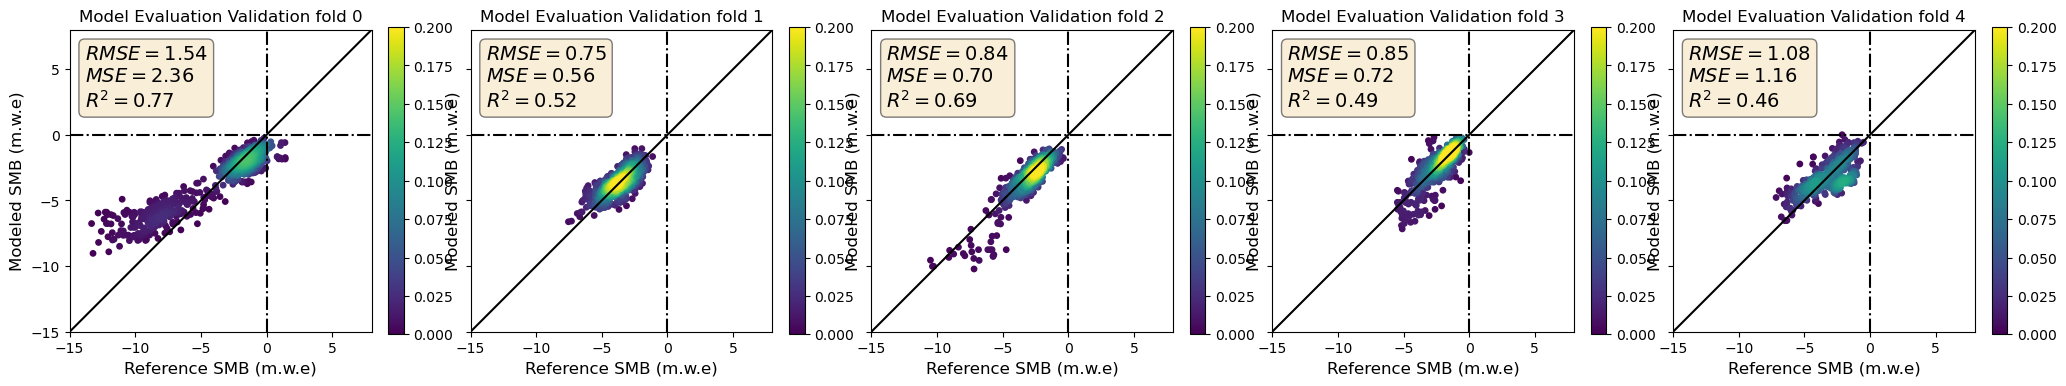

In [44]:
# Plot each of annual, winter and summer separately

fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    indices = np.argwhere((X_test == 6))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    plot_prediction_subplot(y_test_crop, y_pred_crop, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

In [26]:
y_pred_list = []
y_test_list = []
i=0
months=12

for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation'

    indices = np.argwhere((X_test == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    y_test_list.extend(y_test_crop)
    y_pred_list.extend(y_pred_crop)


    i=i+1

# Arrays of predictions and observations for each fold
y_test_all = np.hstack([*y_test_list])
y_pred_all = np.hstack([*y_pred_list])

#plot_prediction(y_test_all, y_pred_all, title, n_toplot=5000, fold=False)

#fig.show()

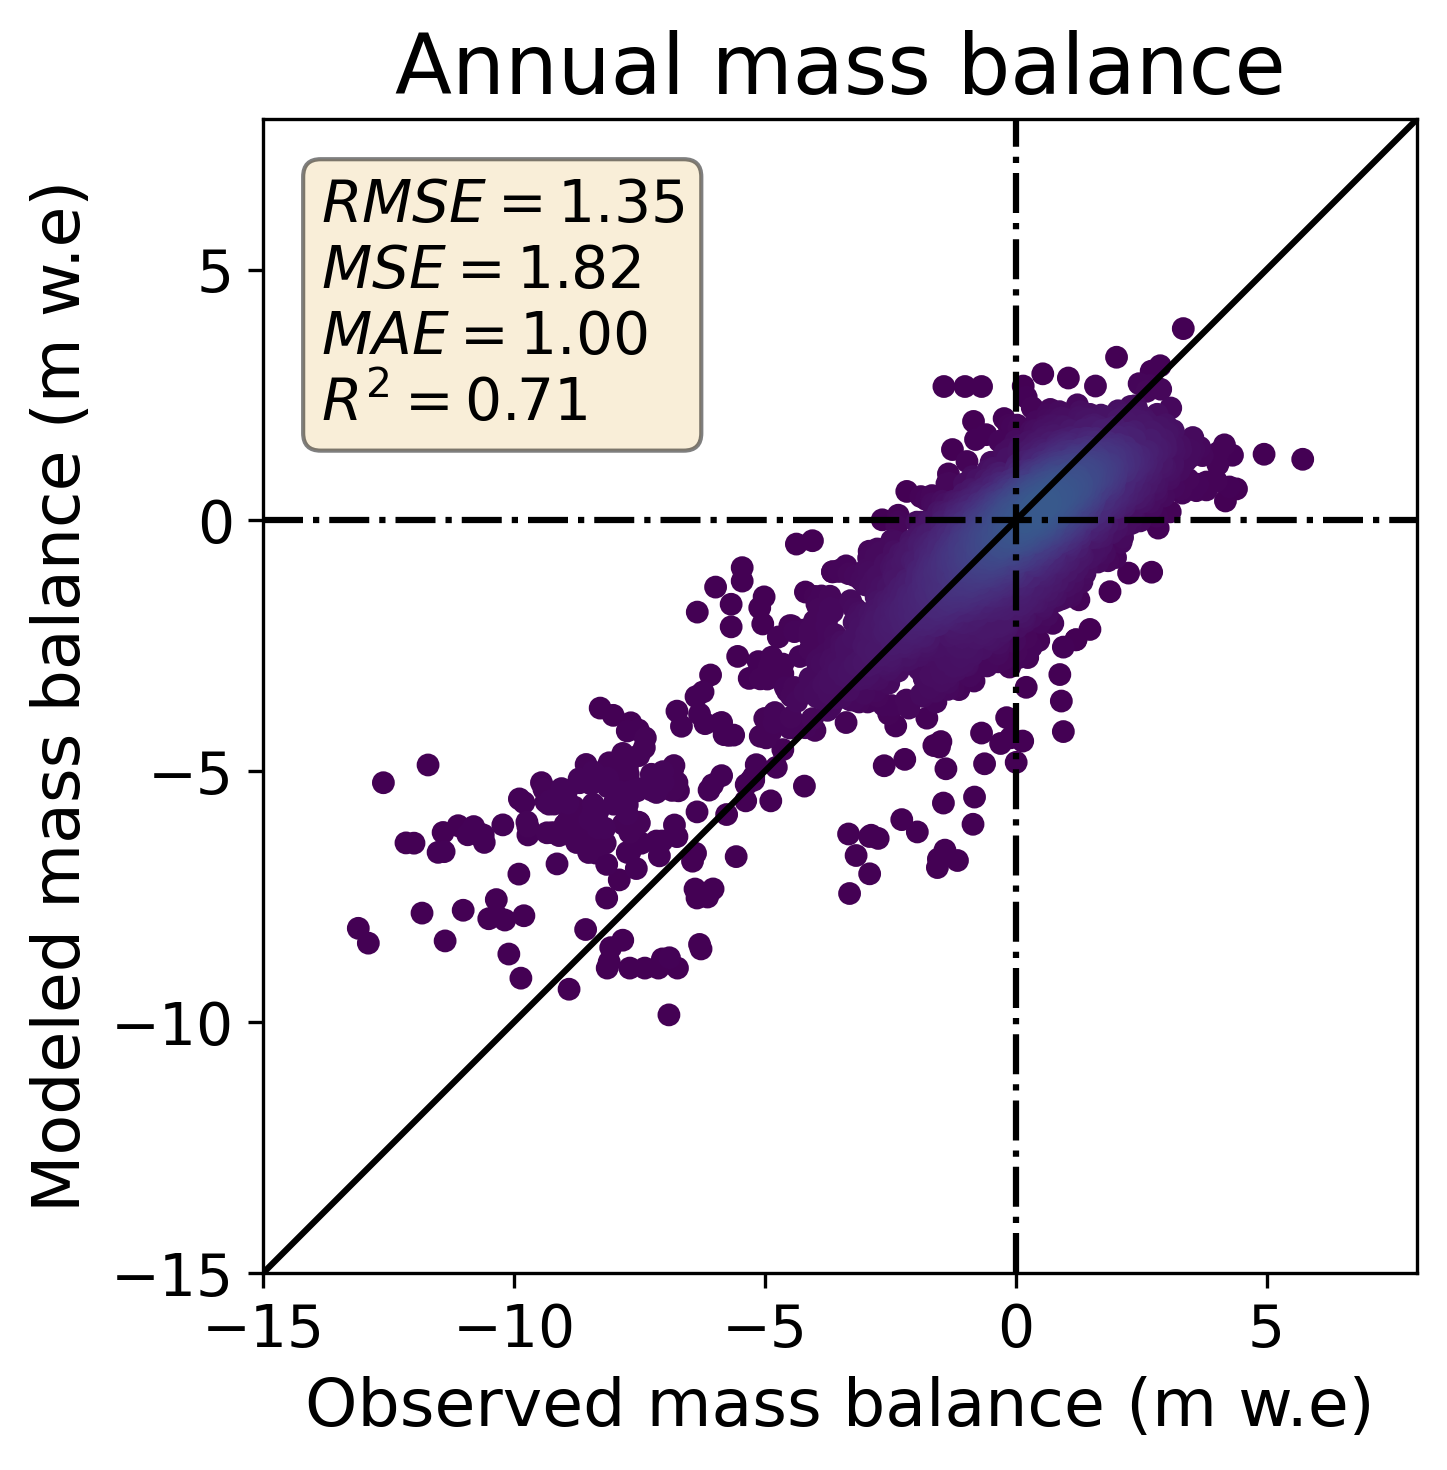

In [27]:
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

figsize=(5,5)
fontsize=16
s= 20
n_toplot=10**10
    
idxs = np.arange(len(y_test_all))
np.random.shuffle(idxs)

y_max = 8#7 #max(max(y1), max(y2))[0] + 1
y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
y_expected = y_test_all.reshape(-1)[idxs[:n_toplot]]
y_predicted = y_pred_all.reshape(-1)[idxs[:n_toplot]]

xy = np.vstack([y_expected, y_predicted])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
fig = plt.figure(figsize=figsize, dpi=300)
plt.title("Annual mass balance", fontsize=20)
plt.ylabel('Modeled mass balance (m w.e)', fontsize=fontsize)
plt.xlabel('Observed mass balance (m w.e)', fontsize=fontsize)
sc = plt.scatter(y_plt, ann_plt, c=z, s=s)
plt.clim(0,0.4)
plt.tick_params(labelsize=14)
#plt.colorbar(sc) 
lineStart = y_min
lineEnd = y_max
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
plt.axvline(0.0, ls='-.', c='k')
plt.axhline(0.0, ls='-.', c='k')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.gca().set_box_aspect(1)
    
textstr = '\n'.join((
r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
r'$MAE=%.2f$' % (mean_absolute_error(y_expected, y_predicted), ),
r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('Figures/mod_vs_obs.png')
plt.show()


In [115]:
# Plot residuals vs elevation and location

type = 'annual'

lon_list = []
lat_list = []
alt_list = []
breid_list = []
y_pred_list = []
y_test_list = []
i=0

if type=='annual':
    months=12
elif type=='winter':
    months=8
elif type=='summer':
    months=6
else:
    months=12

for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    #X_train_ign, X_test = X_train_s[train_index], X_train_s[test_index]
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    df_features_test = df_train_a_w_s_all_s.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]
    df_features_test_crop = df_features_test.iloc[indices]
    
    X_lat = df_features_test_crop['lat'].values
    X_lon = df_features_test_crop['lon'].values
    X_alt = df_features_test_crop['altitude'].values
    X_breid = df_features_test_crop['BREID'].values

    y_test_list.extend(y_test_crop)
    y_pred_list.extend(y_pred_crop)
    
    lat_list.extend(X_lat.tolist())
    lon_list.extend(X_lon.tolist())
    alt_list.extend(X_alt.tolist())
    breid_list.extend(X_breid.tolist())

    i=i+1
        
# Arrays of predictions and observations for each fold
lat_all = np.hstack([*lat_list])
lon_all = np.hstack([*lon_list])
alt_all = np.hstack([*alt_list])
breid_all = np.hstack([*breid_list])
y_test_all = np.hstack([*y_test_list])
y_pred_all = np.hstack([*y_pred_list])
residuals_cropped = y_test_all - y_pred_all

In [116]:
mask_alt = alt_all >=850
alt_masked = alt_all[mask_alt]
y_pred_masked = y_pred_all[mask_alt]
y_test_masked = y_test_all[mask_alt]

In [117]:
# Approx 200 points below 850 masl are removed
print(alt_masked.shape)
print(alt_all.shape)

(2785,)
(2984,)


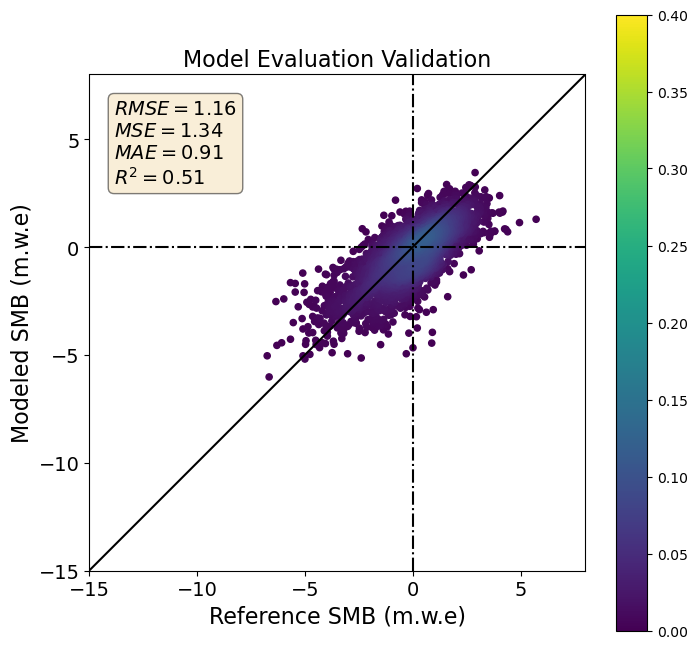

In [118]:
plot_prediction(y_test_masked, y_pred_masked, data_type='Validation')

C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\2159290595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\2159290595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_24104\2159290595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

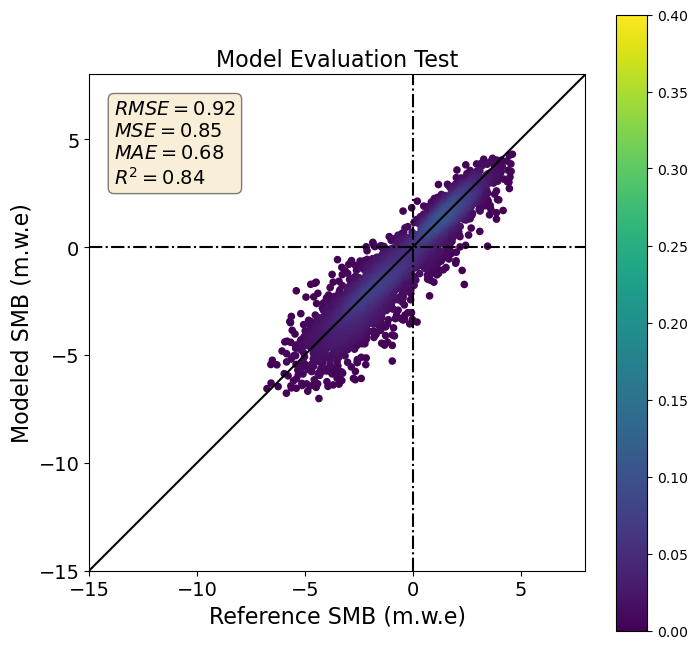

In [146]:
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

var = ['t2m', 'tp'] # Training only temp & prec

mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_test_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_test_summer_clean[name+'_'+mon]= np.nan

df_test_all = pd.concat([df_test_annual_clean, df_test_summer_clean, df_test_winter_clean])
df_test_all.reset_index(drop=True, inplace=True)

# Select features for training
df_test_X = df_test_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_all[['balance']]

X_test, y_test = df_test_X.values, df_test_y.values

test_model = xgb.XGBRegressor(**cv_grid.best_params_)
test_model.fit(X_train_s, y_train_s)
y_pred_test = test_model.predict(X_test)
plot_prediction(y_test, y_pred_test, data_type='Test')

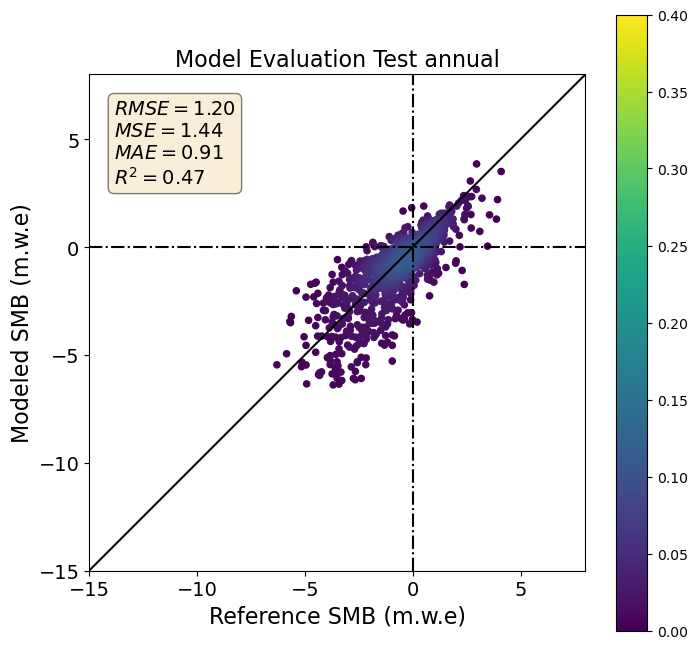

In [149]:
indices = np.argwhere((X_test == 12))[:,0]
y_test_crop = y_test[indices]
y_pred_test_crop = y_pred_test[indices]
plot_prediction(y_test_crop, y_pred_test_crop, data_type='Test annual')

## Upweigh negative values

In [31]:
# Upweigh strongly negative values in df_train_all

df_train_all_neg = df_train_all[df_train_all['balance']<-5.0]
df_train_all_neg

,BREID,altitude,balance,aspect,slope,slope_factor,u10_oct,u10_nov,u10_dec,u10_jan,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
691,1094,440.0,-6.14,5.914623,0.314418,2.002147,-0.841364,-1.925646,0.356887,-0.631991,...,0.005311,0.003324,0.003883,0.005543,0.002657,0.007658,0.010889,0.007453,668.694474,12
692,1094,475.0,-6.35,5.914623,0.314418,2.002147,-0.841364,-1.925646,0.356887,-0.631991,...,0.005311,0.003324,0.003883,0.005543,0.002657,0.007658,0.010889,0.007453,668.694474,12
693,1094,510.0,-6.03,5.914623,0.314418,2.002147,-0.841364,-1.925646,0.356887,-0.631991,...,0.005311,0.003324,0.003883,0.005543,0.002657,0.007658,0.010889,0.007453,668.694474,12
694,1094,550.0,-7.46,5.914623,0.314418,2.002147,-0.841364,-1.925646,0.356887,-0.631991,...,0.005311,0.003324,0.003883,0.005543,0.002657,0.007658,0.010889,0.007453,668.694474,12
695,1094,300.0,-8.90,5.914623,0.314418,2.002147,-0.006159,-0.645988,0.382595,-2.016193,...,0.003320,0.007004,0.003806,0.001045,0.002863,0.006906,0.007138,0.009438,668.694474,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3755,3133,1223.0,-5.55,6.055873,0.173783,2.857561,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.004756,0.004748,0.005446,0.011757,958.993627,6
3833,3137,975.0,-5.50,3.765528,0.129122,3.415070,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.002685,0.007930,0.009902,0.012081,917.419759,6
3835,3137,961.0,-6.04,3.754384,0.135376,3.319519,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.009117,0.006428,0.006298,0.011443,917.419759,6
3840,3137,939.0,-5.13,3.569083,0.195918,2.659230,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.005235,0.008926,0.011151,0.009556,917.419759,6


In [32]:
df_train_all_upweighed = pd.concat([df_train_all, df_train_all_neg])

In [33]:
# Shuffle df_train, get X and y values
df_train_s = df_train_all_upweighed.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)


In [34]:
# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

In [35]:
# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [36]:
print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2085 2148 2474 2514 2597 2743 2768 2772
 2968 3126 3128 3129 3133 3137 3138]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2085 2148 2297 2474 2514 2597 2743 2768 2772
 2968 3126 3128 3129 3133 3137 3138]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1092 1144 2078 2085 2148 2297 2514 2597 2772 2968 3128 3129
 3133 3138]
Validation, fold 2:  [1094 2474 2743 2768 3126 3137]
Train, fold 3:  [ 596 1092 1094 1144 2078 2085 2297 2474 2597 2743 2768 2772 3126 3133
 3137]
Validation, fold 3:  [ 675 2148 2514 2968 3128 3129 3138]
Train, fold 4:  [ 675 1094 2078 2148 2297 2474 2514 2743 2768 2968 3126 3128 3129 3137
 3138]
Validation, fold 4:  [ 596 1092 1144 2085 2597 2772 3133]


In [40]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6],
          'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700, 800], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Cross validation score:  -1.5940112095524797
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 700}
Cross validation scores per fold:  [-2.81004969 -1.03414057 -1.40039613 -0.77148223 -1.95398742]
Mean cross validation score:  -1.5940112095524797
Standard deviation:  0.7260617477297995


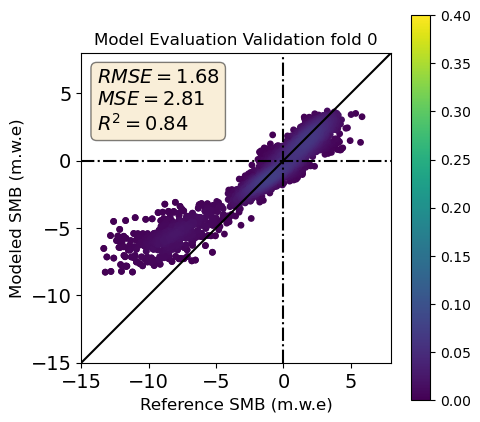

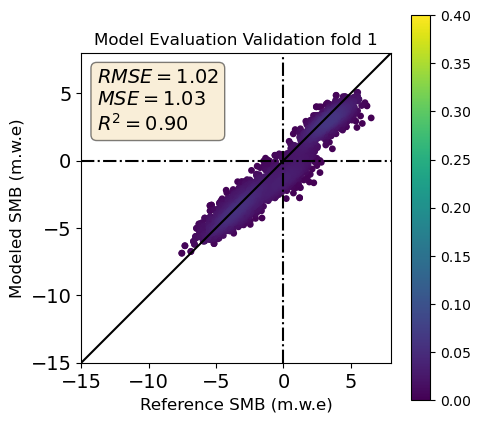

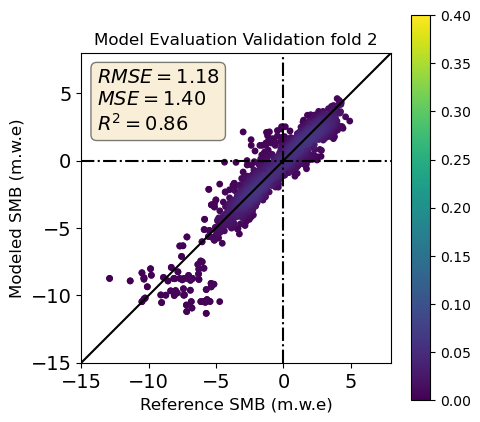

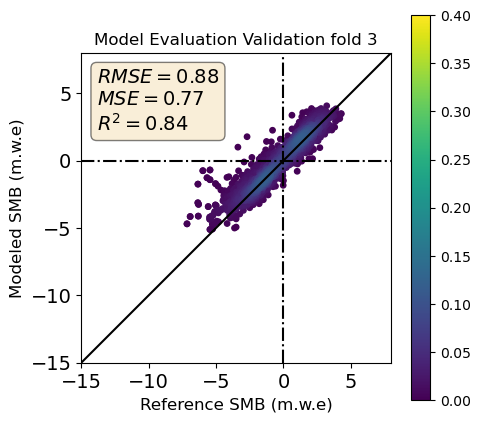

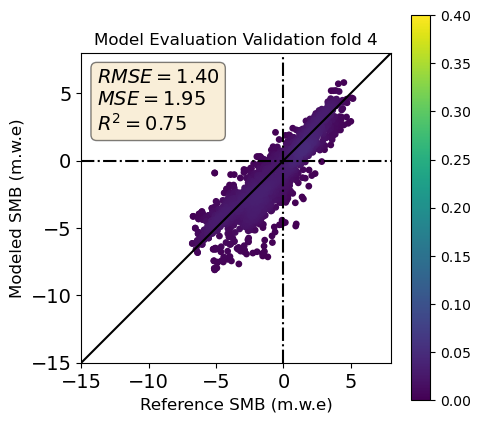

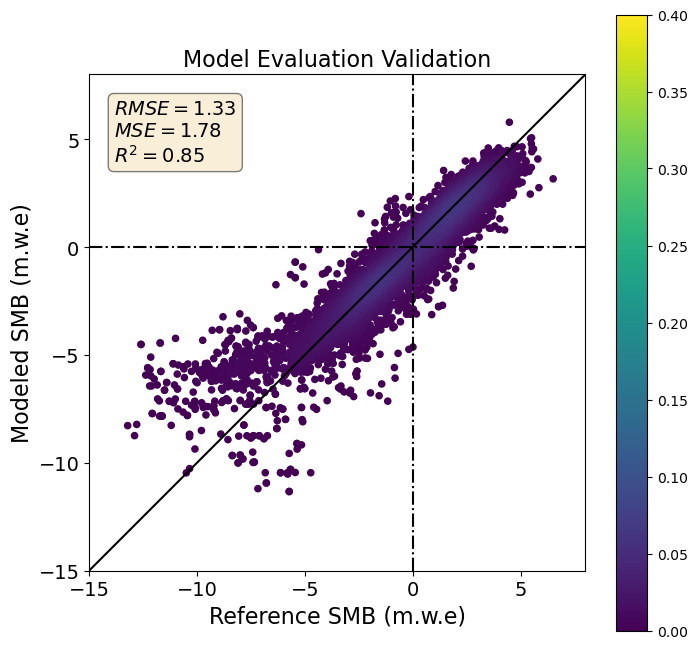

In [41]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

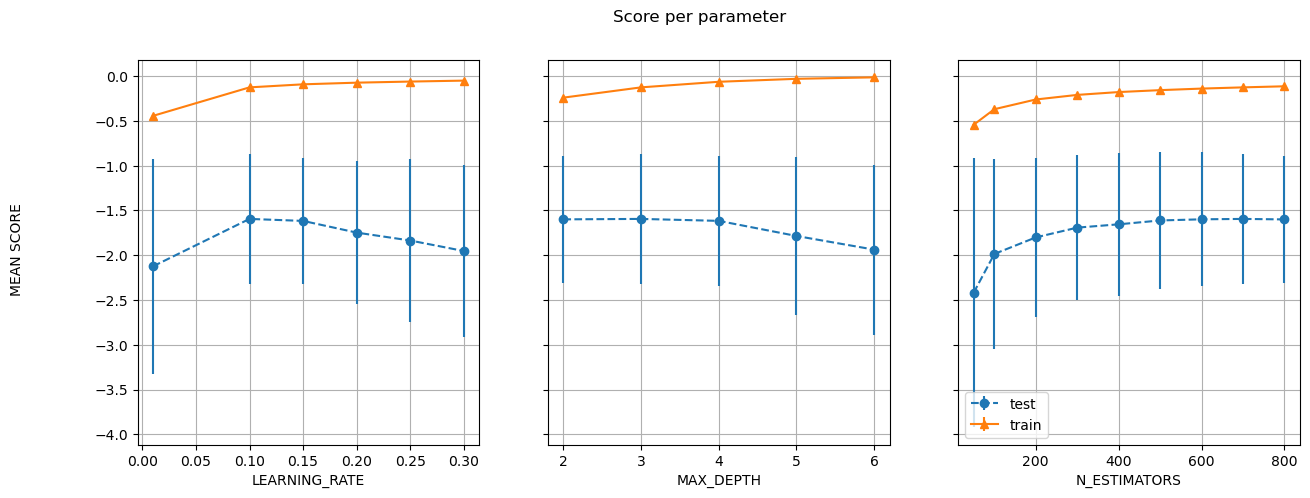

In [42]:
plot_gsearch_results(cv_grid)

C:\Users\kasj\AppData\Local\Temp\ipykernel_9076\184212899.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


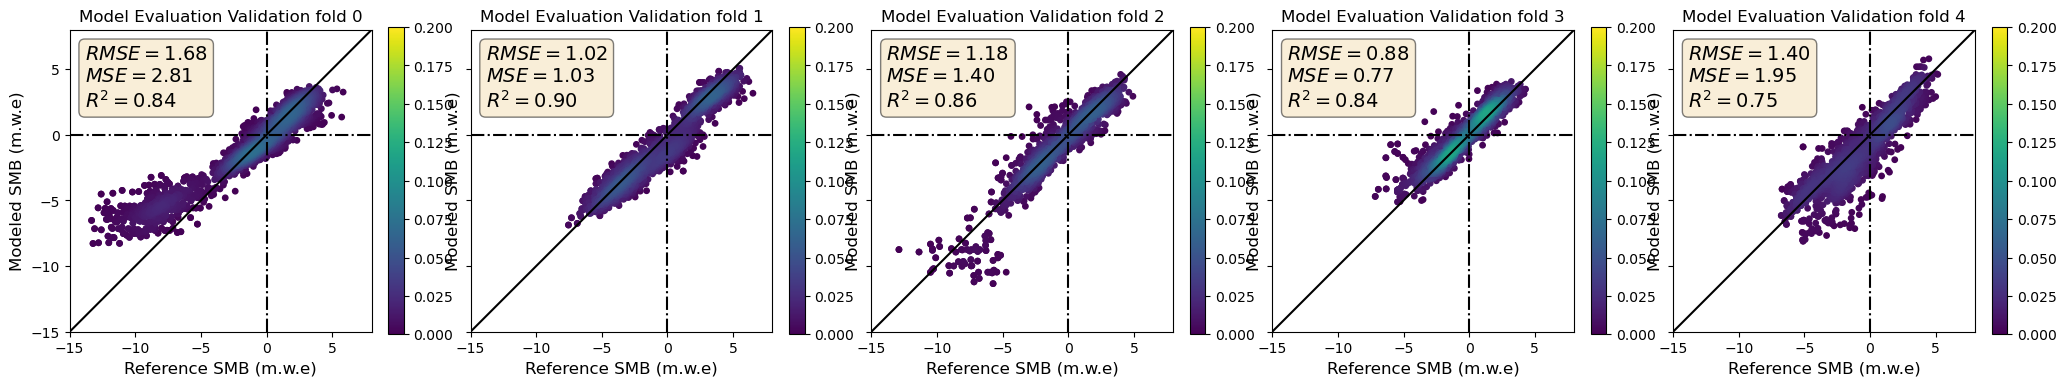

In [43]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    plot_prediction_subplot(y_test, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

## Train model with aggregated climate features (only annual mass balance)

In [ ]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)


In [ ]:
# Manually select 11 test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2320, 2478, 2769, 3127, 3141]
#703, 2085
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# GlacierID has no_annual/no_winter/no_summer points Location
# 54 has 189/174/172 points Finnmark (Langfjordjøkelen)
# 703 has 30/30/31 points Narvik
#NOT USED# 675 has 178 points Narvik
# 941 has 70/71/70 points Blåmannsisen (Bodø)
# 1135 has 56/29/29 points Svartisen sør
# 1280 has 71/57/72 points Breiaren (nær Svartisen)
# 2320 has 83/83/84 points Jostedalsbreen
# 2085 has 163/157/157 points Ålfotbreen
# 2478 has 89/89/89 points Jostedalsbreen
# 2769 has 121/116/116 points Jotunheimen
# 3127 has 145/144/157 points Folgefonna
# 3141 has 72/70/70 points Folgefonna
# Test dataset has 1089/1020/1047 points in total, approximately 27% of the data
# Train dataset has 2821/2732/2882 points, approximately 73% of the data

df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


In [ ]:
# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6

In [ ]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon', 'slope_factor']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
#sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']
sol_rad_down = ['ssrd_oct','ssrd_nov','ssrd_dec','ssrd_jan','ssrd_feb','ssrd_mar','ssrd_apr','ssrd_may','ssrd_jun','ssrd_jul','ssrd_aug','ssrd_sep']
u_wind = ['u10_oct','u10_nov','u10_dec','u10_jan','u10_feb','u10_mar','u10_apr','u10_may','u10_jun','u10_jul','u10_aug','u10_sep']
v_wind = ['v10_oct','v10_nov','v10_dec','v10_jan','v10_feb','v10_mar','v10_apr','v10_may','v10_jun','v10_jul','v10_aug','v10_sep']
f_albedo = ['fal_oct','fal_nov','fal_dec','fal_jan','fal_feb','fal_mar','fal_apr','fal_may','fal_jun','fal_jul','fal_aug','fal_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, dewpt_temp, surface_pressure, 
                         sol_rad_down, sol_therm_down, u_wind, v_wind, f_albedo] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

In [ ]:
# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)

#var = ['u10', 'v10', 't2m', 'fal', 'sshf', 'slhf', 'ssr', 'str', 'tp']
var = ['t2m', 'sshf', 'slhf', 'ssr', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

In [ ]:
# Combine the three dataframes
#df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])
df_train_all = df_train_annual_clean.copy()

In [ ]:
# Get mean values of meteorological variables
var_mean = ['t2m']
var_sum = ['sshf', 'slhf', 'ssr', 'str', 'tp']

spring = ['mar', 'apr', 'may']
summer = ['jun','jul','aug']
winter = ['dec','jan','feb']
fall = ['sep','oct','nov']

for name in var_sum:
    df_train_all[name+'_sp']= df_train_all[[name + '_' + e for e in spring]].sum(axis=1)
    df_train_all[name+'_su']= df_train_all[[name + '_' + e for e in summer]].sum(axis=1)
    df_train_all[name+'_wi']= df_train_all[[name + '_' + e for e in winter]].sum(axis=1)
    df_train_all[name+'_fa']= df_train_all[[name + '_' + e for e in fall]].sum(axis=1)

for name in var_mean:
    df_train_all[name+'_sp']= df_train_all[[name + '_' + e for e in spring]].mean(axis=1)
    df_train_all[name+'_su']= df_train_all[[name + '_' + e for e in summer]].mean(axis=1)
    df_train_all[name+'_wi']= df_train_all[[name + '_' + e for e in winter]].mean(axis=1)
    df_train_all[name+'_fa']= df_train_all[[name + '_' + e for e in fall]].mean(axis=1)

In [ ]:
df_train_all = df_train_all[['BREID','altitude','altitude_climate','balance','aspect','slope','t2m_sp','t2m_su','t2m_wi','t2m_fa','tp_sp','tp_su','tp_wi','tp_fa','sshf_sp','sshf_su','sshf_wi','sshf_fa', 'slhf_sp','slhf_su','slhf_wi','slhf_fa',
                             'ssr_sp','ssr_su','ssr_wi','ssr_fa','str_sp','str_su','str_wi','str_fa']]

In [ ]:
# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [ ]:
# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [ ]:
print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

In [ ]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

In [ ]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [ ]:
#joblib.dump(cv_grid, 'Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_mean_climate_ann_only.pkl')
cv_grid = joblib.load('Models/Block_glacier_5fold_ann+seas/cv_block_glacier_5fold_mean_climate_ann_only.pkl')
fitted_model = xgb.XGBRegressor(**cv_grid.best_params_)

In [ ]:
def plot_prediction_subplot(y1, y2, data_type:str, ax, n_toplot=10**10, fold=False):
    """
    Plot model predictions y1 vs. actual observations y2 and show
    calculated error metrics.

    Parameters:
    y1 : np.array
        Predicted labels.
    y2 : np.array
        Actual labels.
    data_type : str
        Type of data, e.g. "Validation" or "Test".
    ax : array
        Axis object
    n_toplot : int
        Number of points to plot. 
    """
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error

    if fold:
        figsize=(5,5)
        fontsize=12
        s= 15
    else:
        figsize=(8,8)
        fontsize=16
        s= 20
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)

    y_max = 8#7 #max(max(y1), max(y2))[0] + 1
    y_min = -15#1 #min(min(y1), min(y2))[0] - 1
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    #fig = plt.figure(figsize=figsize)
    sc = ax.scatter(y_plt, ann_plt, c=z, s=s)
    sc.set_clim(0,0.2)
    #plt.tick_params(labelsize=14)
    plt.colorbar(sc,ax=ax,fraction=0.046) 
    lineStart = y_min
    lineEnd = y_max
    ax.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    ax.set_title("Model Evaluation " + data_type, fontsize=fontsize)
    ax.set_ylabel('Modeled SMB (m.w.e)', fontsize=fontsize)
    ax.set_xlabel('Reference SMB (m.w.e)', fontsize=fontsize)
    ax.axvline(0.0, ls='-.', c='k')
    ax.axhline(0.0, ls='-.', c='k')
    ax.set_xlim(lineStart, lineEnd)
    ax.set_ylim(lineStart, lineEnd)
    ax.set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=False), ),
    r'$MSE=%.2f$' % (mean_squared_error(y_expected, y_predicted, squared=True), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    return ax
    #plt.show()

In [ ]:
fig, ax = plt.subplots(1,5, sharex=True, sharey=True, figsize=(25,25))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #y_test_list.extend(y_test)
    #y_pred_list.extend(y_pred)

    title = 'Validation fold ' + str(a)

    #indices = np.argwhere((X_test == 6))[:,0]
    #y_test_crop = y_test[indices]
    #y_pred_crop = y_pred[indices]

    #plot_prediction_subplot(y_test_crop, y_pred_crop, title, ax[a], n_toplot=5000, fold=True)
    plot_prediction_subplot(y_test, y_pred, title, ax[a], n_toplot=5000, fold=True)

    a=a+1

fig.show()

In [ ]:
# Plot permutation importance

max_features_plot = 28

fig, ax = plt.subplots(1,5, figsize=(30,10))
a = 0    
for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]

    best_model.fit(X_train, y_train)
    
    result = permutation_importance(best_model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=10)

    sorted_idx = result.importances_mean.argsort()
    labels = np.array(df_train_X_s.columns)[sorted_idx][-max_features_plot:]
    
    ax[a].boxplot(result.importances[sorted_idx].T[:,-max_features_plot:], vert=False, labels=labels)
    ax[a].set_title("Permutation Importance Fold " + str(a))

    a=a+1

fig.show()

In [ ]:
# Plot residuals vs elevation and location

type = 'annual'

lon_list = []
lat_list = []
alt_list = []
breid_list = []
y_pred_list = []
y_test_list = []
i=0

if type=='annual':
    months=12
elif type=='winter':
    months=8
elif type=='summer':
    months=6
else:
    months=12

for train_index, test_index in splits_s:
    # Loops over n_splits iterations and gets train and test splits in each fold
    #X_train_ign, X_test = X_train_s[train_index], X_train_s[test_index]
    X_train, X_test = X_train_s[train_index], X_train_s[test_index]
    y_train, y_test = y_train_s[train_index], y_train_s[test_index]
    df_features_test = df_train_s.iloc[test_index]

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    #indices = np.argwhere((X_test == months))[:,0]
    #y_test_crop = y_test[indices]
    #y_pred_crop = y_pred[indices]
    #df_features_test_crop = df_features_test.iloc[indices]
    
    #X_lat = df_features_test['lat'].values
    #X_lon = df_features_test['lon'].values
    X_alt = df_features_test['altitude'].values
    #X_breid = df_features_test['BREID'].values

    y_test_list.extend(y_test)
    y_pred_list.extend(y_pred)
    
    #lat_list.extend(X_lat.tolist())
    #lon_list.extend(X_lon.tolist())
    alt_list.extend(X_alt.tolist())
    #breid_list.extend(X_breid.tolist())

    i=i+1
        
# Arrays of predictions and observations for each fold
#lat_all = np.hstack([*lat_list])
#lon_all = np.hstack([*lon_list])
alt_all = np.hstack([*alt_list])
#breid_all = np.hstack([*breid_list])
y_test_all = np.hstack([*y_test_list])
y_pred_all = np.hstack([*y_pred_list])
residuals_cropped = y_test_all - y_pred_all

In [ ]:
mask_alt = alt_all >=850
alt_masked = alt_all[mask_alt]
y_pred_masked = y_pred_all[mask_alt]
y_test_masked = y_test_all[mask_alt]
# Approx 200 points below 850 masl are removed
print(alt_masked.shape)
print(alt_all.shape)

In [ ]:
plot_prediction(y_test_masked, y_pred_masked, data_type='Validation')

In [ ]:
df_test_annual['n_months']=12
df_test_winter['n_months']=8
df_test_summer['n_months']=6

# Select features for training
df_test_annual_clean = df_test_annual.drop(drop_cols, axis=1)
df_test_winter_clean = df_test_winter.drop(drop_cols, axis=1)
df_test_summer_clean = df_test_summer.drop(drop_cols, axis=1)
df_test_annual_clean = df_test_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_test_winter_clean = df_test_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_test_summer_clean = df_test_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_test_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_test_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_test_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

df_test_all = df_test_annual_clean.copy()

# Get mean values of meteorological variables
var_mean = ['t2m']
var_sum = ['sshf', 'slhf', 'ssr', 'str', 'tp']

spring = ['mar', 'apr', 'may']
summer = ['jun','jul','aug']
winter = ['dec','jan','feb']
fall = ['sep','oct','nov']


for name in var_sum:
    df_test_all[name+'_sp']= df_test_all[[name + '_' + e for e in spring]].sum(axis=1)
    df_test_all[name+'_su']= df_test_all[[name + '_' + e for e in summer]].sum(axis=1)
    df_test_all[name+'_wi']= df_test_all[[name + '_' + e for e in winter]].sum(axis=1)
    df_test_all[name+'_fa']= df_test_all[[name + '_' + e for e in fall]].sum(axis=1)

for name in var_mean:
    df_test_all[name+'_sp']= df_test_all[[name + '_' + e for e in spring]].mean(axis=1)
    df_test_all[name+'_su']= df_test_all[[name + '_' + e for e in summer]].mean(axis=1)
    df_test_all[name+'_wi']= df_test_all[[name + '_' + e for e in winter]].mean(axis=1)
    df_test_all[name+'_fa']= df_test_all[[name + '_' + e for e in fall]].mean(axis=1)


df_test_all = df_test_all[['BREID','altitude','altitude_climate','balance','aspect','slope','t2m_sp','t2m_su','t2m_wi','t2m_fa','tp_sp','tp_su','tp_wi','tp_fa','sshf_sp','sshf_su','sshf_wi','sshf_fa', 'slhf_sp','slhf_su','slhf_wi','slhf_fa',
                             'ssr_sp','ssr_su','ssr_wi','ssr_fa','str_sp','str_su','str_wi','str_fa']]

# Select features for training
df_test_X = df_test_all.drop(['balance','BREID'], axis=1)

# Select labels for training
df_test_y = df_test_all[['balance']]

X_test, y_test = df_test_X.values, df_test_y.values

test_model = xgb.XGBRegressor(**cv_grid.best_params_)
test_model.fit(X_train_s, y_train_s)
y_pred_test = test_model.predict(X_test)
plot_prediction(y_test, y_pred_test, data_type='Test')

